In [1]:
%load_ext autoreload
%autoreload 2

from score_models.plot_utils import *
from score_models.toy_distributions import *
from score_models import MLP, ScoreModel, VESDE, VPSDE, CosineVPSDE
import torch

/home/alexandre/anaconda3/envs/caustic/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

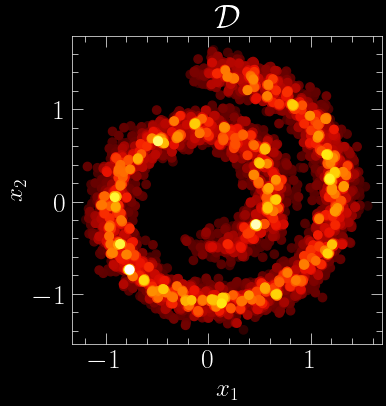

In [3]:
distribution = swiss_roll()

D = int(2**12)
data = distribution.sample((D,))
dataset = Dataset(data)

ax = plot_scatter(data, bins=100)
ax.set_title(r"$\mathcal{D}$")
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");


In [12]:
C = 2
layers = 4
width = int(2**7)
fourier_scale = 0.02

# sde = VESDE(1e-2, 10)
# sde = VPSDE(1e-2, 20, epsilon=1e-5)
sde = CosineVPSDE(100, epsilon=1e-3)
net = MLP(C, layers=layers, width=width, fourier_scale=fourier_scale)
model = ScoreModel(net, sde, formulation="edm")

In [13]:
E = 400
lr = 1e-3
batch_size = int(2**8)
ema_decay = 0.99

losses = model.fit(dataset, epochs=E, learning_rate=lr, batch_size=batch_size, ema_decay=ema_decay)

No path provided. Training checkpoints will not be saved.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 400 | Cost: 7.0e-01 |: 100%|██████████| 400/400 [01:22<00:00,  4.85it/s]

Finished training after 0.023 hours.


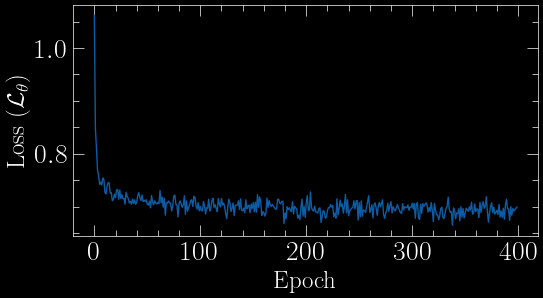

In [14]:
plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.ylabel(r"Loss ($\mathcal{L}_\theta$)")
plt.xlabel("Epoch");

In [15]:
samples = model.sample(shape=(D, C), steps=100)

t=0.01 | sigma=0.02 | x=0.3±0.8: 100%|██████████| 100/100 [00:02<00:00, 36.74it/s]


t=1 | sigma=1 | x=-0.004±5: 100%|██████████| 20/20 [00:02<00:00,  7.33it/s]      


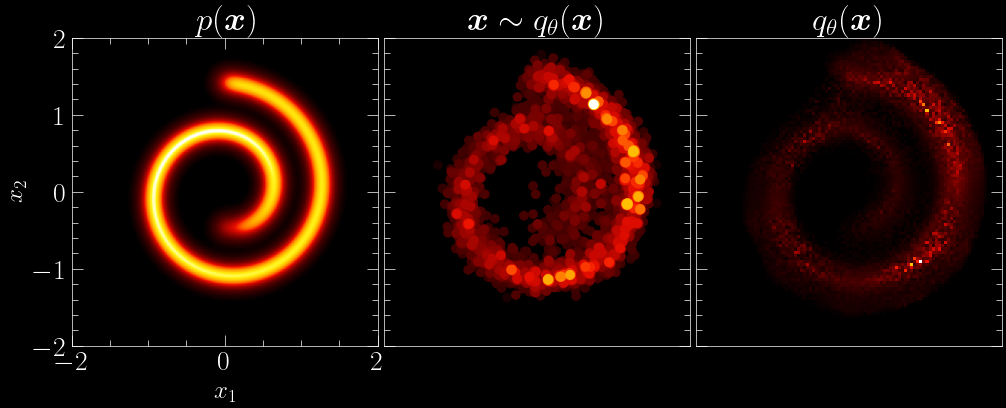

In [16]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
extent = (-2, 2, -2, 2)

plot_density(distribution.log_prob, bins=200, extent=extent, ax=ax0);
plot_scatter(samples, bins=100, ax=ax1, extent=extent);
plot_density(lambda x: model.log_prob(x, steps=20), bins=100, extent=extent, ax=ax2);

ax0.set_xlabel(r"$x_1$")
ax0.set_ylabel(r"$x_2$")
ax1.set_xticks([])
ax2.set_xticks([])
ax0.set_title(r"$p(\bm{x})$")
ax1.set_title(r"$\bm{x} \sim q_\theta(\bm{x})$")
ax2.set_title(r"$q_\theta(\bm{x})$")

plt.subplots_adjust(wspace=0.02);